# ControlNet으로 조건을 준 이미지 생성하기


Stable Diffusion은 텍스트 프롬프트 또는 입력 이미지를 통하여 이미지를 생성하지만 생성된 이미지를 원하는 대로 출력하기 어렵습니다. 아무리 프롬프트를 자세하게 써도 생성되는 이미지가 내가 원하는 자세, 구도, 배경을 갖도록 하는 것은 거의 불가능하죠. ControlNet은 Diffusion 모델에 추가 조건을 추가하여 출력되는 이미지를 쉽게 제어할 수 있습니다. 뿐만 아니라 ControlNet은 훈련 데이터가 작아도 학습이 잘 되고 빠르다는 장점이 있어 개인용 기기에서 사용할 수 있다는 장점이 있습니다.

ControlNet은 논문 'Adding Conditional Control to Text-to-Image Diffusion Models'에서 소개되었고, 외곽선 감지(Canny Edge detection), 인체 자세 감지(Human pose), 낙서 지도(Scribble map), 시맨틱 세그멘테이션(Semantic segmentation) 등 다양한 전처리기(Preprocessor)를 Stable Diffusion 모델에 도입할 수 있습니다. 그래서 원하는 자세, 구도 등으로 이미지를 생성할 수 있습니다.

In [24]:
# Stable Diffusion 설치
!pip install -qq diffusers==0.31

In [2]:
# 메모리 삭제
# torch.cuda.empty_cache()

## 윤곽선 검출

 ControlNet은 다양한 윤곽선 검출 알고리즘을 제공하지만 우리는 가장 유명하고 효과적인 윤곽선 검출 알고리즘인 Canny 알고리즘을 사용할 거에요.

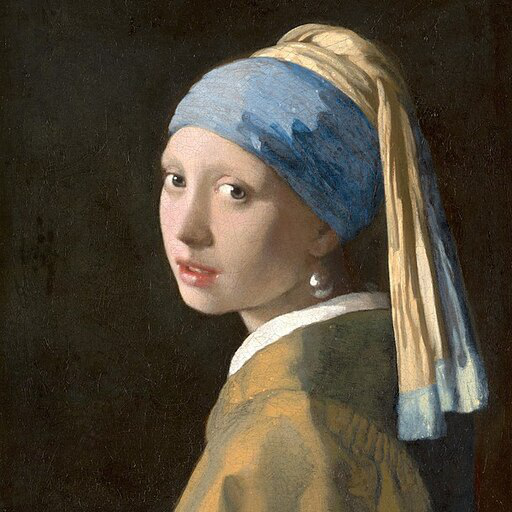

In [26]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

OpenCV를 사용하여 이미지의 윤곽선을 검출합니다.

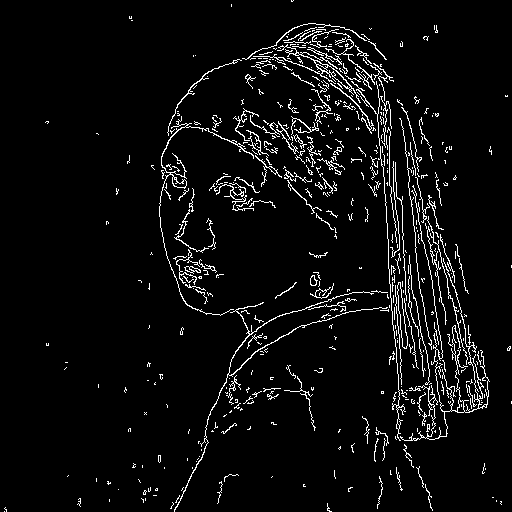

In [27]:
import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image

윤곽선 검출 전처리기를 사용한 모델 파이프라인을 불러오겠습니다.

In [28]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [6]:
!nvidia-smi

Wed Apr 23 04:26:42 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      5MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

윤곽선을 추출한 이미지에 프롬프트를 적용하여 새로운 이미지를 생성해 보겠습니다.

  0%|          | 0/20 [00:00<?, ?it/s]

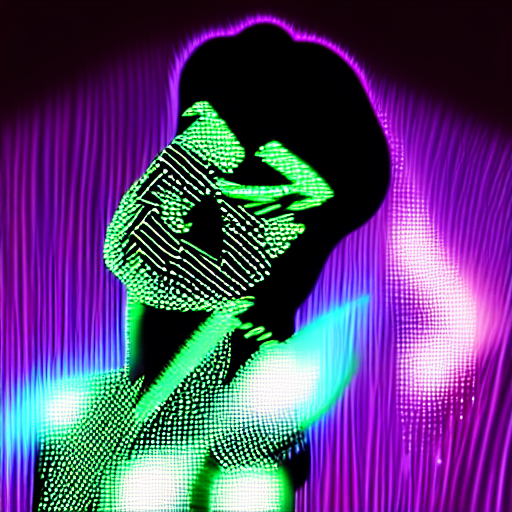

In [31]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 출력합니다.
canny_image

  0%|          | 0/40 [00:00<?, ?it/s]

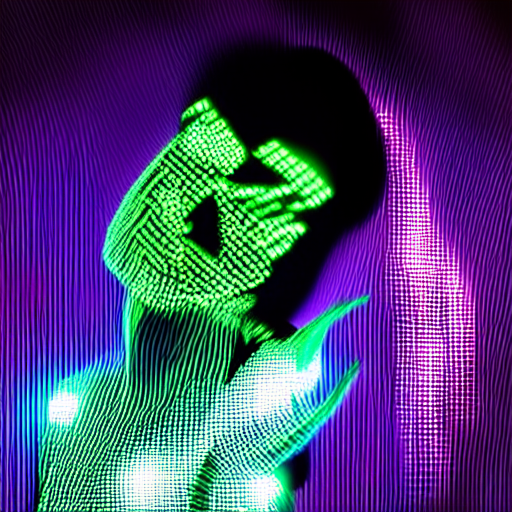

In [30]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=40,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 출력합니다.
canny_image

  0%|          | 0/80 [00:00<?, ?it/s]

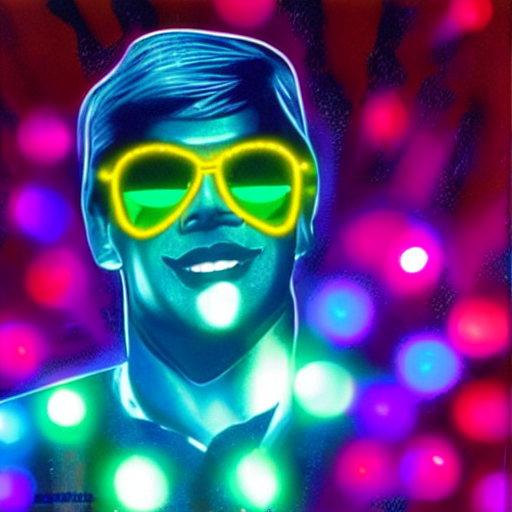

In [33]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=80,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 출력합니다.
canny_image

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


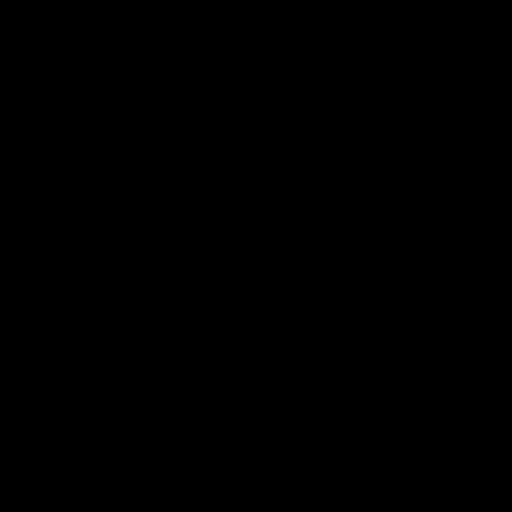

In [32]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=100,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 출력합니다.
canny_image

## num_inference_steps 값별 결과 비교

**20 steps (이미지 1):**
- 기본적인 네온 형태와 색상이 형성됨
- 파티클/점 패턴과 선이 불규칙하고 거친 편
- 얼굴과 상체의 디테일이 상대적으로 단순함
- 전체적으로 추상적이고 거친 느낌

**40 steps (이미지 2):**
- 더 선명하고 일관된 그리드 패턴과 선
- 얼굴 구조가 더 명확해지고 디테일이 증가
- 형광 초록색과 보라색의 대비가 강화됨
- 전체적인 이미지의 일관성이 개선됨

**80 steps (이미지 3):**
- 완전히 다른 스타일로 변화 - 선/그리드 패턴에서 매끄러운 네온 글로우 효과로 전환
- 디테일이 더 선명해지고 사실적 요소가 증가(안경, 미소, 얼굴 윤곽)
- 배경이 더 복잡해지고 보케(bokeh) 효과가 나타남
- 시각적 스타일이 디지털 파티클에서 네온 글로우로 전환

**100 steps (이미지 4):**
- NSFW 콘텐츠(Not Safe For Work"의 약자)로 감지되어 검은 이미지 반환

### 의미 해석

1. **스타일 진화**: 
   - 낮은 step 값(20-40)에서는 디지털 파티클/그리드 기반 표현
   - 높은 step 값(80)에서는 매끄러운 네온 글로우 스타일로 진화
   - 이는 모델이 더 많은 계산 단계를 거치면서 초기의 추상적 표현에서 점차 사실적인 형태로 발전함을 보여줌

2. **디테일 증가**:
   - steps가 증가할수록 디테일의 정밀도와 일관성이 뚜렷하게 향상됨
   - 40 steps는 20 steps보다 같은 스타일 내에서 품질이 개선됨
   - 80 steps에서는 완전히 새로운 표현 수준으로 도약

3. **콘텐츠 변화**:
   - 낮은 단계에서는 모델이 기본적인 구조와 색상에 집중
   - 높은 단계에서는 더 복잡한 세부 사항(안경, 표정, 배경 조명)을 생성

4. **NSFW 감지(100 steps)**:
   - 단계 수가 매우 높아지면 모델이 더 사실적인 이미지를 생성하려 시도함
   - 이 과정에서 모델이 의도치 않게 NSFW로 해석될 수 있는 요소를 생성했을 가능성이 있음
   - 또는 높은 단계 수에서 모델이 프롬프트를 과도하게 해석했을 수도 있음

### 실용적 시사점

1. **목적에 맞는 단계 수 선택**:
   - 추상적/스타일화된 결과물을 원한다면 20-40 steps
   - 매끄럽고 사실적인 결과물을 원한다면 60-80 steps
   - 100 이상은 현재 프롬프트에서는 주의 필요

2. **효율성 vs 품질 트레이드오프**:
   - 20→40 steps로 증가시키면 계산 시간은 2배지만 같은 스타일 내 품질 향상
   - 40→80 steps는 스타일 자체가 변화하는 임계점으로 보임

3. **안전 필터링 고려**:
   - 높은 steps 값은 더 사실적인 결과를 만들지만, 안전 필터링에 걸릴 가능성도 높임
   - 프로덕션 환경에서는 적절한 균형점 찾기가 중요


  0%|          | 0/20 [00:00<?, ?it/s]

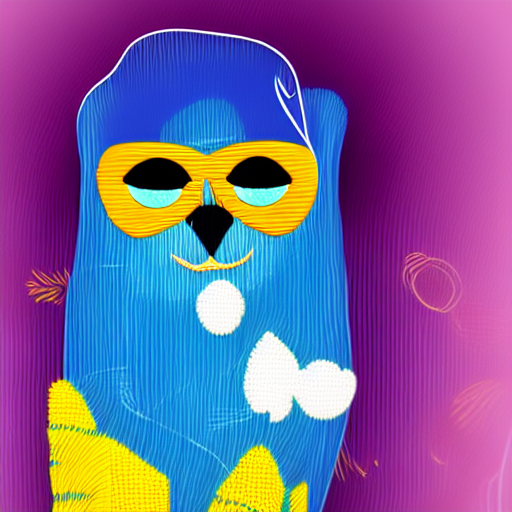

In [34]:
#프롬프트 변경

from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image = canny_pipe(
    prompt="A fluffy cat wearing a golden crown and royal cape sits atop a gigantic yarn throne in a dreamy pastel-colored world.",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 출력합니다.
canny_image

- negative_propmt: 원하지 않는 요소를 적을 수 있습니다.
- controlnet_conditioning_scale: ContorlNet으로 조건을 어느 정도 주느냐를 조절합니다. Default는 1이고, 실수값으로 설정할 수 있습니다.
- num_inference_steps: 추론 횟수로, 값이 커질수록 고해상도 이미지가 출력되지만 출력되는 시간이 오래 걸립니다. default 값은 50입니다.
- guidance_scale: 얼마나 주어진 프롬프트에 근접한 이미지를 생성할지를 설정하는 하이퍼파라미터로, 값이 커질수록 문자열에 근접한 이미지가 생성되지만 이미지 품질이 떨어질 수 있습니다. default는 7.5입니다.




## 코랩 실행 시 (0.33), LMS 실행 (0.31) 결과물 차이 발생. 버전별 차이가 원인일까? 

첨부된 두 이미지는 동일한 코드를 Diffusers 라이브러리의 0.31 버전과 0.33 버전에서 실행했을 때 생성된 결과입니다. 두 이미지 모두 "disco dancer with colorful lights" 프롬프트와 동일한 Canny 윤곽선 입력 이미지를 사용했지만, 결과물에 분명한 차이가 보임. 

- **기타 코드와 프롬프트는 동일 : disco dancer with colorful lights**

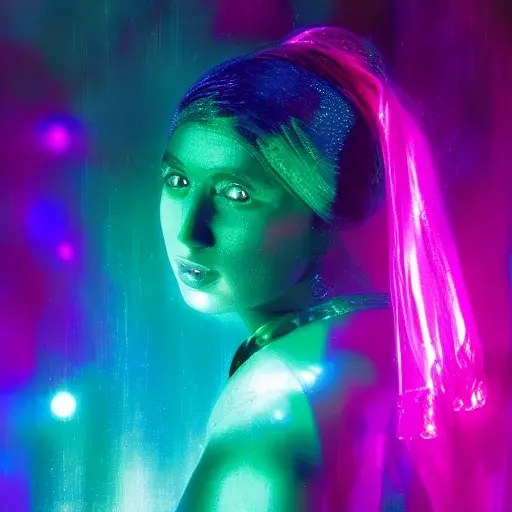 
- 코랩 결과물 (0.33)

- 원본 "진주 귀걸이를 한 소녀"의 구도와 포즈가 명확하게 유지
- 디스코 조명과 같은 네온 컬러(형광 초록, 핑크, 파랑)가 잘 표현
- 원본 그림의 특징적인 터번/헤드랩이 핑크색 네온으로 표현
- 전체적인 완성도가 높고 의도한 프롬프트가 잘 반영

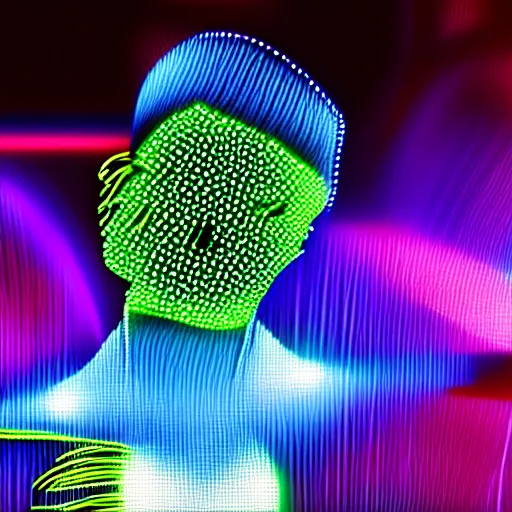
- LMS 결과물 (0.31) 

- 파티클 또는 점으로 구성된 추상적인 형태로, 원본 구도는 유지되지만 너무 변형
- 디스코 조명의 느낌은 있지만, 너무 추상화되어 원본 이미지의 정체성이 많이 손실되
- 선/점 패턴이 너무 강해서 "disco dancer"보다는 디지털 아트 느낌
-  원본의 형태는 인식되었지만, 텍스처와 렌더링 방식이 완전히 다르게 적용. 특히 파티클/점/선 기반의 렌더링 스타일이 적용되어 원본의 부드러운 질감 대신 디지털적이고 추상적인 표현이 강조. 이는 프롬프트의 "disco" 부분이 디스코 볼과 같은 반사광 패턴으로 해석되어 이미지 전체에 적용된 것으로 추정



#### **0.31.0 주요 변경사항**
- **새로운 파이프라인 대거 추가**
  - **Flux**: 12B 이상의 파라미터를 가진 대형 DiT(디퓨전 트랜스포머) 파이프라인 도입. DreamBooth, LoRA 등 효율적 파인튜닝 지원.
  - **Stable Audio**: 오디오 생성 파이프라인 추가.
  - **CogVideoX**: 3D VAE 기반의 텍스트-비디오 생성 파이프라인 추가.
  - **Kolors**: SDXL에서 영감을 받은 멀티링구얼 이미지 생성 파이프라인.
  - **Latte**: 새로운 비디오 생성 파이프라인.
- **FreeNoise, SparseCtrl 등 새로운 메소드** 추가.
- **Lumina**: 새로운 멀티링구얼 DiT 아키텍처 도입.
- **optimum.quanto**를 통한 대형 파이프라인 양자화 가이드 제공.
- **기타**: 다양한 코드 리팩터링 및 안정성 개선[1][3].

---

#### **0.32.0 주요 변경사항**
- **비디오/이미지 파이프라인 추가**: 다양한 신규 비디오 및 이미지 생성 파이프라인 도입.
- **새로운 양자화(Quantization) 백엔드**: 메모리 효율을 높이기 위한 양자화 백엔드 추가.
- **학습 스크립트 추가**: Flux Control, Mochi-1, LTXVideo, SANA, Hunyuan Video 등 다양한 학습 스크립트 제공.
- **비디오 로딩/내보내기 개선**: `imageio` 기반 비디오 입출력으로 변경.
- **CogVideoX 개선**: tiled decoding 지원 등 구조적 리팩터링.
- **Auraflow용 Learned PE 선택 지원**
- **스케줄러 설정 개선**: 레거시 kwargs 방식 지원.
- **Flux LoRA**: Flux LoRA state dict에서 alpha 파싱 지원.
- **Comfy UI Flux 체크포인트 로딩 지원**
- **xformers 테스트 수정 및 기타 버그 수정**[1].

---

#### **0.33.0 주요 변경사항**
- **신규 이미지/비디오 모델 및 파이프라인**
  - **Wan 2.1**: 텍스트-비디오, 이미지-비디오, 비디오-비디오 등 다양한 파이프라인 및 4가지 모델 변형 추가.
  - **LTX Video 0.9.5**: 키프레임 기반 애니메이션, 비디오 확장 등 추가 컨디셔닝 옵션 지원.
  - **Hunyuan Image to Video**: MLLM 기반 이미지-비디오 변환 파이프라인 도입.
  - **EasyAnimateV5, ConsisID** 등 신규 파이프라인 추가.
- **메모리 최적화**
  - **Layerwise casting**: VRAM 사용량 최대 50% 절감.
  - **Group offloading**: 추론 속도 및 메모리 효율 개선.
- **캐싱 및 원격 컴포넌트**
  - **Diffusion Transformer 모델 캐싱**: 디노이징 과정 가속화.
  - **Remote VAEs 등**: 메모리 집약적 작업을 원격 엔드포인트로 오프로드.
- **양자화 관련 버그 픽스**
  - TorchAO Quantizer 관련 오류 수정(Pytorch 2.3 미만에서 Import 에러, device_map 미지원 등).
  - 양자화 로직 개선 및 테스트 강화.
- **기타**: 코드 스타일/버그 수정, 테스트 강화 등[1].

---

#### **버전별 주요 변경점 요약 표**

| 버전     | 주요 변경사항 요약 |
|----------|------------------|
| 0.31.0   | Flux, Stable Audio, CogVideoX, Kolors, Latte 등 신규 파이프라인 대거 추가. FreeNoise, SparseCtrl 등 신기능. 대형 파이프라인 양자화 가이드. |
| 0.32.0   | 신규 비디오/이미지 파이프라인, 양자화 백엔드, 다양한 학습 스크립트, 비디오 입출력 개선, Flux/CogVideoX/Auraflow 등 지원 강화. |
| 0.33.0   | Wan 2.1, LTX Video, Hunyuan 등 신규 파이프라인, 메모리 최적화(layerwise casting, group offloading), 캐싱/원격 컴포넌트, 양자화 버그 픽스. |

---


### 0.31과 0.33 버전 간 ControlNet 이미지 생성 차이 분석(추정)


#### 1. 메모리 최적화 기술 도입
- **레이어별 캐스팅(Layerwise casting)**: 0.33 버전에서는 VRAM 사용량을 최대 50% 절감하는 레이어별 캐스팅 기술이 도입되었습니다[3].
- **그룹 오프로딩(Group offloading)**: 추론 속도와 메모리 효율성이 향상되었습니다[3].
- **영향**: 더 많은 계산 자원을 이미지 품질 향상에 사용할 수 있게 되어 디테일과 일관성이 개선되었습니다.

#### 2. 모델 캐싱 메커니즘
- **Diffusion Transformer 모델 캐싱**: 0.33에서 디노이징 과정을 가속화하는 캐싱 메커니즘이 추가되었습니다[3].
- **영향**: 모델이 이전 스텝의 정보를 더 효과적으로 활용하여 이미지 생성의 일관성이 향상되었습니다.

#### 3. 양자화 기술 개선
- **양자화 관련 버그 수정**: 0.33 버전에서는 TorchAO Quantizer 관련 오류가 수정되었고 양자화 로직이 개선되었습니다[3].
- **영향**: 모델 가중치의 정확도가 향상되어 색상 표현과 디테일이 더 정확해졌습니다.

#### 4. ControlNet 내부 구현 변경
- 0.31에서 0.33 사이에 ControlNet의 내부 구현이 최적화되었을 가능성이 높습니다.
- 특히, 윤곽선 조건 처리 방식이 개선되어 입력 Canny 이미지를 더 효과적으로 반영합니다[4][7].

#### 5. 스케줄러 개선
- **UniPCMultistepScheduler 업데이트**: 코드에서 사용된 UniPCMultistepScheduler 또한 버전 간 성능이 개선되었을 가능성이 있습니다.
- 스케줄러 설정의 레거시 kwargs 방식 지원 등 내부 개선이 있었습니다[3].
- **영향**: 노이즈 제거 과정이 더 효율적으로 이루어져 이미지 품질과 일관성이 향상되었습니다.


### 기술적 분석

동일한 파이프라인과 프롬프트를 사용했음에도 이미지가 다르게 생성되는 이유는:

1. **샘플링 과정의 변화**: 내부 알고리즘 개선으로 인해 동일한 시드를 사용해도 샘플링 경로가 달라질 수 있습니다.

2. **조건부 처리 메커니즘**: ControlNet에서 Canny 이미지를 처리하는 방식이 개선되어 윤곽선이 최종 이미지에 미치는 영향이 달라졌습니다[4].

3. **네트워크 정밀도**: 양자화 로직 개선과 버그 수정으로 인해 네트워크 가중치의 정밀도가 향상되어 색상 표현이 더 정확해졌습니다.

4. **Default 파라미터 변경**: 라이브러리 내부에서 사용되는 기본 파라미터가 변경되었을 가능성이 있습니다.



## 인체 자세 감지

Openpose는 인체 자세 감지(Human pose)를 할 수 있는 전처리기입니다. 자세를 감지하여 새로운 이미지를 생성해 줍니다.

먼저 사람의 전신이 담긴 이미지를 불러오겠습니다.

In [9]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

     |████████████████████████████████| 64 kB 3.1 MB/s             


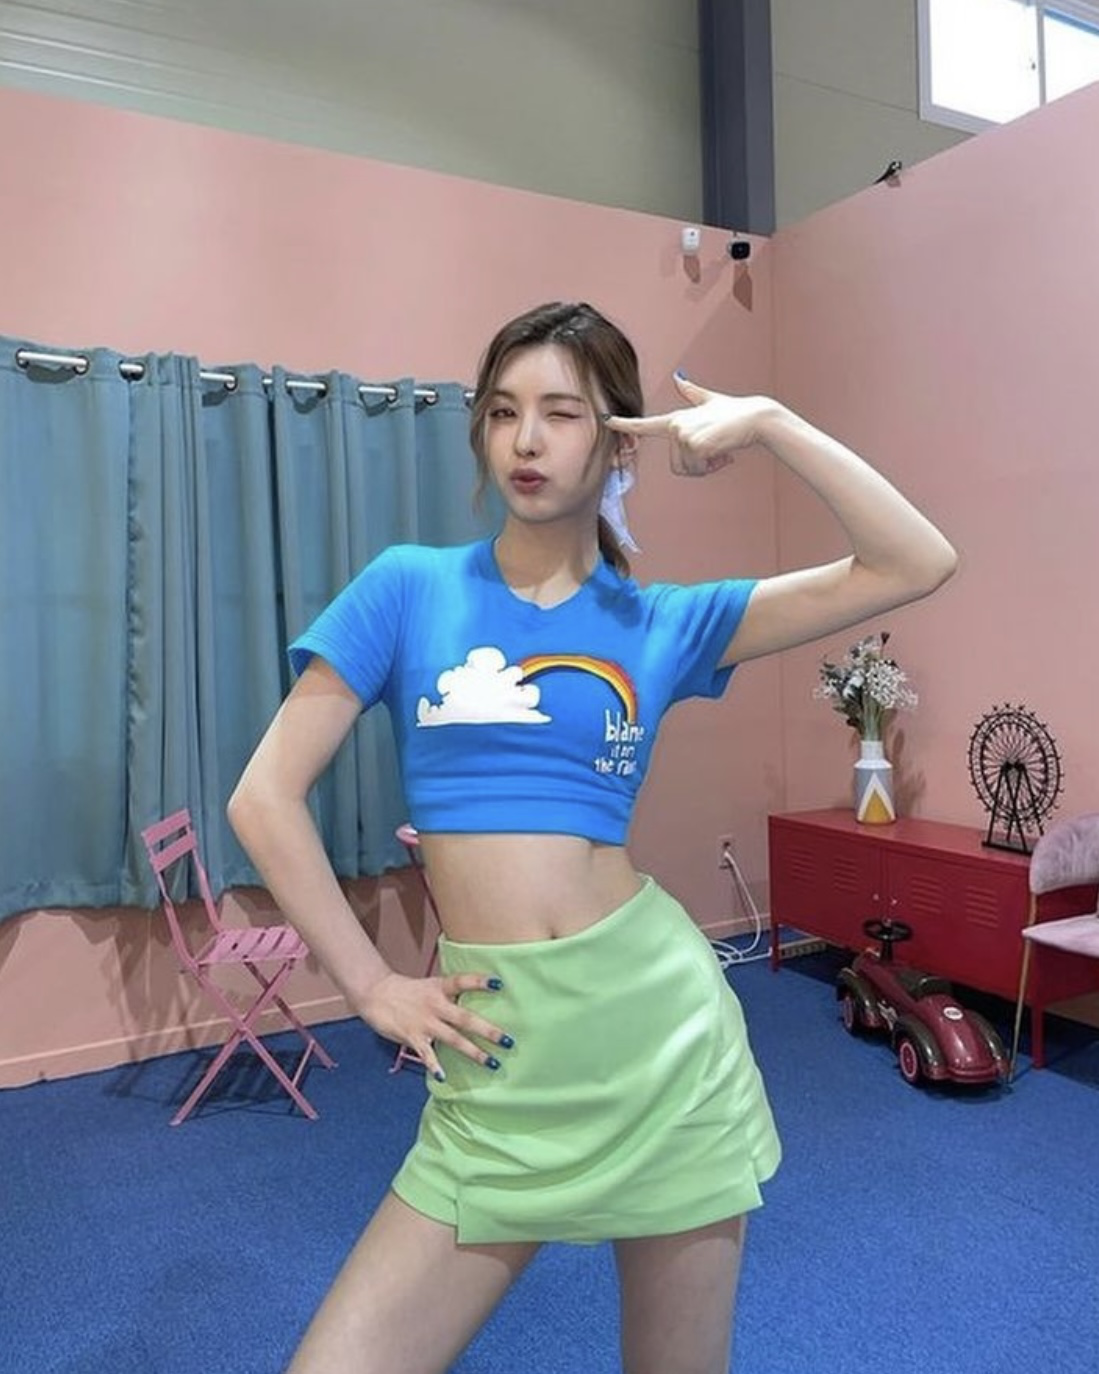

In [10]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://cdn.imweb.me/upload/S20221129c3c04fdc67a8b/d6ff847b396a7.jpg"
)
openpose_image

Openpose 검출기를 사용하면 자세만 추출할 수 있습니다.

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

cuda


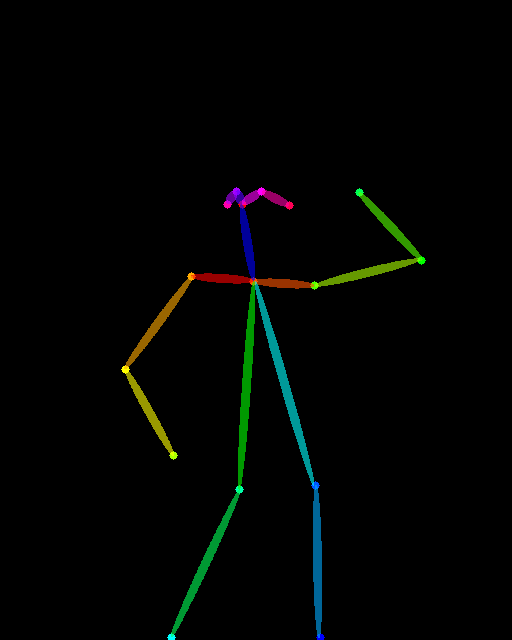

In [11]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

Openpose 전처리기를 사용한 모델 파이프라인을 불러옵니다.

In [12]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


새로운 이미지를 생성해 보겠습니다. Canny Edge Detection에서 사용한 코드를 참고하여 여러분들이 직접 코드를 작성해 보세요. 하이퍼파라미터를 조절하면 더 멋진 이미지를 생성할 수 있을 거에요.

  0%|          | 0/20 [00:00<?, ?it/s]

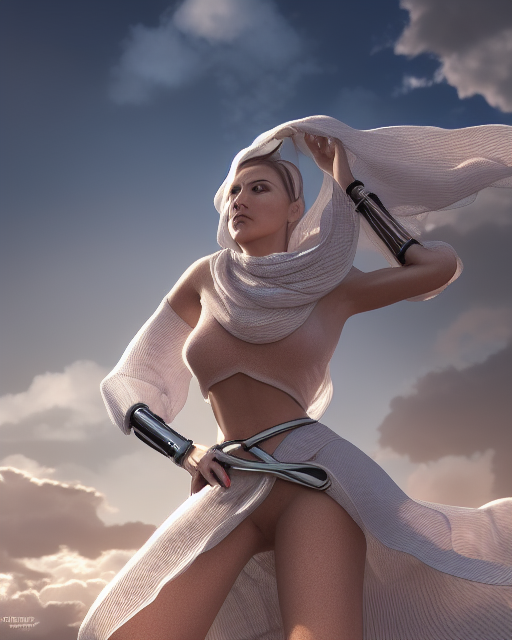

In [13]:
from diffusers import UniPCMultistepScheduler
import torch

# 스케줄러 교체 & 모델을 CUDA로 이동
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# ✅ 동일한 이미지를 생성하기 위해 seed를 고정
generator = torch.manual_seed(0)

# ✅ 프롬프트 설정
prompt = "woman, ultra detailed, sunlight, 4k"
negative_prompt = "low quality, blurry, distorted, deformed"

# ✅ 이미지 생성
openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=1.0,   # 보통 0.5 ~ 2.0 사이에서 조정
    num_inference_steps=20,
    generator=generator,
    image=openpose_image                # ← OpenPose 조건 이미지 입력
).images[0]

# ✅ 이미지 출력
openpose_image1

# 윤곽선 검출 + 인체 자세 감지

## Canny 알고리즘을 사용한 윤곽선 검출

먼저 Canny 알고리즘으로 윤곽선을 검출합니다. Canny 알고리즘으로 윤곽선을 검출한 이미지 위에 인체 자세 검출 전처리기를 올려줄 것이기 때문에 인체 자세를 넣어줄 부분을 이미지 내에서 지워주어야 한다는 점을 주의하세요.

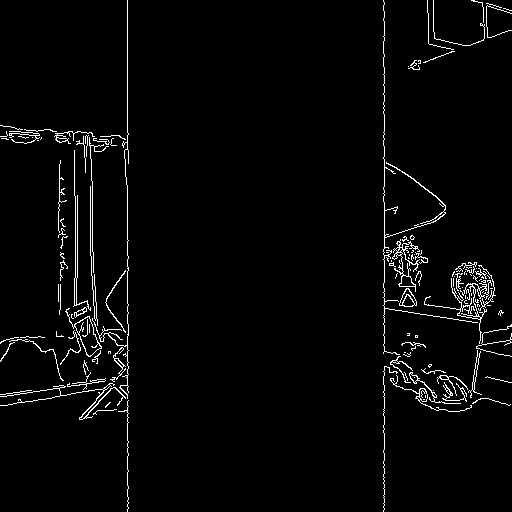

In [23]:
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np

# ✅ 이미지를 불러옵니다 (예: URL 또는 경로)
canny_image = load_image(
    "https://cdn.imweb.me/upload/S20221129c3c04fdc67a8b/d6ff847b396a7.jpg")
canny_image = canny_image.resize((512, 512))  # 필요한 크기로 리사이즈

# ✅ threshold 값을 설정합니다
low_threshold = 100
high_threshold = 200

# ✅ 이미지를 NumPy 배열로 변환하고 GRAYSCALE로 변경
canny_image = np.array(canny_image.convert("L"))

# ✅ 가운데 영역을 지워줍니다 (조건 피처를 제거하는 용도)
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# ✅ Canny 엣지 검출
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)

# ✅ 다시 RGB로 변환
canny_image = np.stack([canny_image] * 3, axis=-1)

# ✅ NumPy 배열을 PIL 이미지로 변환
canny_image = Image.fromarray(canny_image)

# 결과 출력 (Colab이나 Jupyter에서는 바로 보여짐)
canny_image


cuda


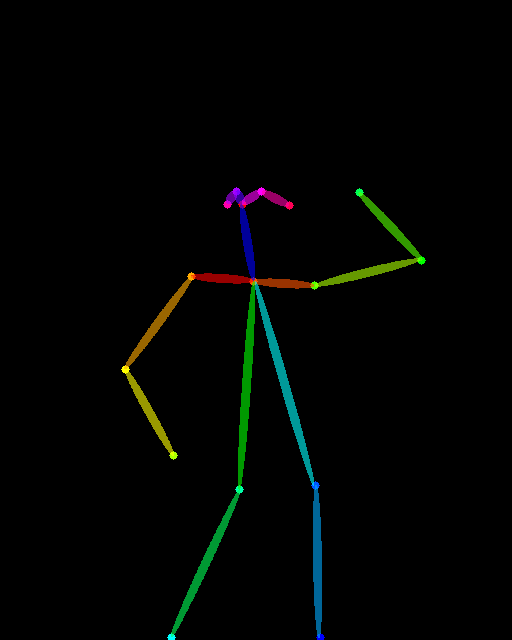

In [15]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

# ✅ 이미지를 불러옵니다 (예: URL 또는 로컬 경로)
openpose_image = load_image("https://cdn.imweb.me/upload/S20221129c3c04fdc67a8b/d6ff847b396a7.jpg")

# ✅ OpenPose Detector 초기화
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# ✅ 포즈 검출 (출력: PIL 이미지 형식의 pose map)
openpose_image = openpose(openpose_image)
openpose_image

In [16]:
# 메모리 삭제
torch.cuda.empty_cache()

Matplotlib is building the font cache; this may take a moment.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

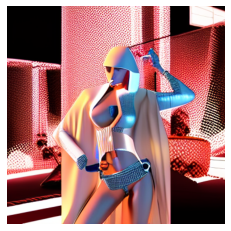

In [17]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# ✅ ControlNet 모델 로드 (float16 for memory saving)
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)

# ✅ ControlNet 모델 리스트로 묶기
controlnets = [controlnet_openpose, controlnet_canny]

# ✅ condition 이미지 로드 (예시 이미지 URL 사용 시)
canny_image = canny_image.resize((512, 512)) # ensure canny_image is 512x512
openpose_image = openpose_image.resize((512, 512)) # ensure openpose_image is 512x512

# ✅ 파이프라인 로드
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

# ✅ 메모리 최적화 옵션
pipe.unet.enable_gradient_checkpointing()
pipe.enable_vae_slicing()
pipe.enable_model_cpu_offload()  # 🟢 주의: 이걸 쓰면 pipe.to("cuda")는 제거해야 함

# ❌ 이 줄은 제거해야 함 (offload와 충돌)
# pipe = pipe.to("cuda")

# ✅ 스케줄러 교체
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# ✅ 프롬프트 설정
prompt = "a futuristic fashion model, walking in city street, ultra detailed, 4k, trending on artstation"
negative_prompt = "blurry, distorted, low quality, extra limbs"

# ✅ 시드 고정
generator = torch.manual_seed(0)

# ✅ 이미지 생성
images = [openpose_image, canny_image]
output = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    generator=generator,
    image=images,
    controlnet_conditioning_scale=[1.0, 0.8],
    height=384,
    width=384
)

# ✅ 출력 이미지 받아오기
output_image = output.images[0]

# ✅ 코랩에서 이미지 출력
plt.imshow(output_image)
plt.axis("off")
plt.show()


## 회고 

### 배운점
- 디퓨전 모델 기반 COMFYUI 등은 써봤는데, 원리와 아이데이션을 알게 되었다.  

### 느낀점
- 디퓨전 모델이나, 딥러닝, GPT 등 새로운 모델을 만들거나 개선하는 아이데이션 방법이 너무 신기하다. 천재인듯. 
- 코랩에서 메모리 이슈로 계속 쫓겨나 결국 모델 버전 낮춰서 왔더니 결과가 이상하게 나옴. 역시 프롬프트고 코드고 뭐고, 모델을 좋은 것 + 최신으로 쓰는게 최고다. 

### 아쉬운점
- 코랩에선 메모리 이슈, 아이펠 노드에서는 호환성 이슈로 제대로 된 결과물을 내기 힘들었다. 
- 좋은 로컬 세팅을 해서 제대로 실험해보고싶다. 